In [56]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
df = pd.read_csv('/content/sample_data/preprocessed_data.csv')
df['clean_tweet'] = df['clean_tweet'].astype(str)

tweets = df['clean_tweet'].values
labels = df['label'].values

In [61]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(tweets)

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length)

In [62]:
y = np.array(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - accuracy: 0.8683 - loss: 0.3198 - val_accuracy: 0.9494 - val_loss: 0.1295
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.9682 - loss: 0.0827 - val_accuracy: 0.9478 - val_loss: 0.1372
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9820 - loss: 0.0521 - val_accuracy: 0.9435 - val_loss: 0.1675
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9898 - loss: 0.0333 - val_accuracy: 0.9373 - val_loss: 0.2088
Epoch 4: early stopping


In [65]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [66]:

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
target_names = ['Appropriate', 'Inappropriate']
report = classification_report(y_test, y_pred, target_names=target_names)

# Print the classification report
print("Classification Report:\n", report)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9362 - loss: 0.1999
Test Loss: 0.2087545394897461
Test Accuracy: 0.9372604489326477
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Classification Report:
                precision    recall  f1-score   support

  Appropriate       0.83      0.79      0.81       835
Inappropriate       0.96      0.97      0.96      4122

     accuracy                           0.94      4957
    macro avg       0.89      0.88      0.89      4957
 weighted avg       0.94      0.94      0.94      4957


Evaluation Metrics:

Accuracy: 0.9372604397821263
Precision: 0.9579428022110069
Recall: 0.9670063076176614
F1-score: 0.9624532174332971


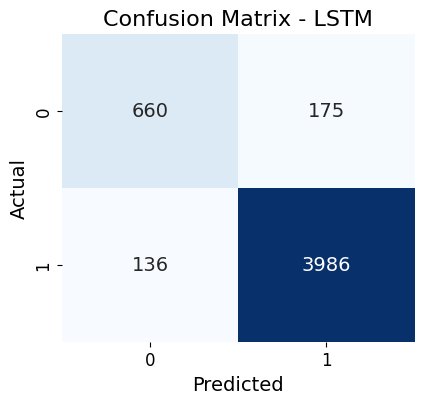

In [67]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - LSTM', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

#============================ Text Preprocessing ============================#

stop_words = set(stopwords.words('english'))
# Remove "yourself" from stopwords so it is not removed in preprocessing
stop_words.discard("yourself")
stop_words.add("rt")  # add "rt" to remove retweet tokens

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    return re.sub(entity_regex, "", raw_text)

def change_user(raw_text):
    regex = r"@([^ ]+)"
    return re.sub(regex, "user", raw_text)

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(url_regex, '', raw_text)

def remove_noise_symbols(raw_text):
    for symbol in ['"', "'", "!", "`", "..", ".", ",", "#", ":", "@", "?"]:
        raw_text = raw_text.replace(symbol, '')
    return raw_text

def remove_stopwords(raw_text):
    tokens = word_tokenize(raw_text)
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

def stemming(raw_text):
    stemmer = PorterStemmer()
    words = raw_text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def preprocess(data):
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean


if __name__ == '__main__':
    custom_text = ["I will hurt you."]
    preprocessed_custom_text = preprocess(custom_text)[0]
    print("Preprocessed Text:", preprocessed_custom_text)

    # Tokenize and pad the sequence
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    tokenizer = Tokenizer(num_words=1000)
    tokenizer.fit_on_texts([preprocessed_custom_text])
    max_length = 10
    custom_sequence = tokenizer.texts_to_sequences([preprocessed_custom_text])
    padded_custom_sequence = pad_sequences(custom_sequence, maxlen=max_length)

    # Dummy model (replace with your actual model)
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

    model = Sequential([
        Embedding(input_dim=1000, output_dim=16, input_length=max_length),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Make prediction
    prediction = model.predict(padded_custom_sequence)
    print("Prediction:", prediction)

    # Interpret the prediction result
    if prediction > 0.5:
        print("Inappropriate.")
    else:
        print("Appropriate.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Text: hurt
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Prediction: [[0.50410336]]
Inappropriate.
